In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sys import path
%matplotlib inline

In [2]:
path.insert(0, '../src')
from setup import data_setup
from data_generator import DataGenerator
from model_trainer import ModelTrainer

In [3]:
dg = data_setup()
norm_data = dg.df()

In [4]:
from data_transformation import get_isotope_data, get_hydrocarbs
isotope_data = get_isotope_data()

In [5]:
from data_transformation import get_suspicious_peaks, get_ranges, get_peak_suspiciousness
original_data = dg.calibrated_df(True, .005, .01,use_ranges=True, ranges=[0.25, 0.5, 0.75], cat=True)
ranges = get_ranges(isotope_data,2000)
original_data['target'] = original_data['target'].apply(lambda a: a - 1 if a > 0 else a)
original_data['sus_peaks'] = original_data['masses'].apply(get_suspicious_peaks, args=(ranges, .1))
original_data['peak_sussness'] = original_data['masses'].apply(get_peak_suspiciousness, args=(ranges, True))

In [6]:
original_data['num_sus_peaks'] = original_data['sus_peaks'].apply(len)
original_data[original_data['target'] == 1].describe()

,Mass/Time,MassOffset,StartFlightTime,SpecBinSize,target,err_prop_slope,err_prop_offset,num_sus_peaks
count,467.000000,467.000000,467.000000,467.000000,467.0,467.000000,467.000000,467.000000
mean,0.317307,-0.237807,3.259349,1.416094,1.0,-0.000007,-0.000185,135.830835
std,0.096472,0.300777,5.452427,2.879854,0.0,0.007591,0.005361,95.656817
min,0.168041,-1.194138,-0.929000,0.138000,1.0,-0.009979,-0.009917,11.000000
25%,0.173148,-0.512371,0.000000,0.138000,1.0,-0.007363,-0.005242,65.000000
50%,0.376764,-0.000202,0.000000,0.138000,1.0,-0.005047,0.000000,116.000000
75%,0.381525,-0.000020,7.114500,1.250000,1.0,0.007424,0.000000,177.500000
max,0.466862,0.001710,21.434000,20.000000,1.0,0.009981,0.009954,545.000000


In [7]:
original_data[original_data['target'] == 0].describe()

,Mass/Time,MassOffset,StartFlightTime,SpecBinSize,target,err_prop_slope,err_prop_offset,num_sus_peaks
count,439.000000,439.000000,439.000000,439.000000,439.0,439.0,439.000000,439.000000
mean,0.320245,-0.226371,3.023271,1.000542,0.0,0.0,0.000113,33.526196
std,0.094050,0.284518,5.147337,1.776526,0.0,0.0,0.005635,62.866523
min,0.168588,-1.093778,0.000000,0.138000,0.0,0.0,-0.009974,0.000000
25%,0.172340,-0.510942,0.000000,0.138000,0.0,0.0,-0.005263,0.000000
50%,0.378245,-0.000250,0.000000,0.138000,0.0,0.0,0.000000,5.000000
75%,0.379367,-0.000015,7.092500,1.250000,0.0,0.0,0.005536,29.000000
max,0.388642,0.000835,21.571000,10.000000,0.0,0.0,0.009988,388.000000


In [8]:
original_data['susness'] = original_data['peak_sussness'].apply(np.mean)

In [9]:
training_data = original_data[original_data['num_sus_peaks'] >= 15].copy()[['peak_sussness', 'num_sus_peaks', 'susness','target']]

In [10]:
def get_n_sussest(susses, n=20):
    a = sorted(susses, reverse=True)
    return susses[0:n]

In [11]:
X = np.vstack(training_data['peak_sussness'].apply(get_n_sussest, args=(15,)))
X = np.hstack([X, np.array(training_data[['num_sus_peaks', 'susness']]).reshape(X.shape[0], 2)])
y = np.array(training_data['target'])

In [12]:
from model_trainer import ModelTrainer
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
models = [RandomForestClassifier, LGBMClassifier, XGBClassifier]
names = ['rfc', 'lgbm', 'xgb']
mt = ModelTrainer(models, X, y, names)

In [13]:
accs, indices_preds = mt.kfold_models(5, model_params=[{'n_estimators': 10}, {}, {}])
accs

[0.9741673223183847, 0.9773800157356411, 0.9773800157356414]

Text(0, 0.5, 'Accuracy')

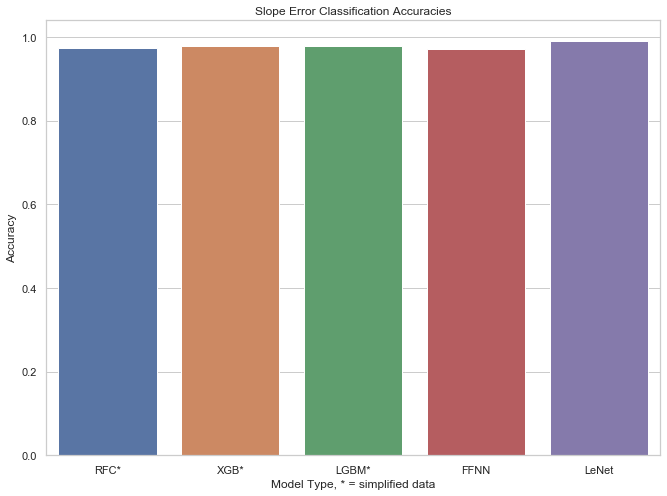

In [15]:
x = accs + [ 0.97, 0.99]
names = ['RFC*', 'XGB*', 'LGBM*', 'FFNN', 'LeNet']
plt.figure(figsize=(11, 8))
sns.set(style='whitegrid')
sns.barplot(y=x, x=names)
plt.title('Slope Error Classification Accuracies')
plt.xlabel('Model Type, * = simplified data')
plt.ylabel('Accuracy')

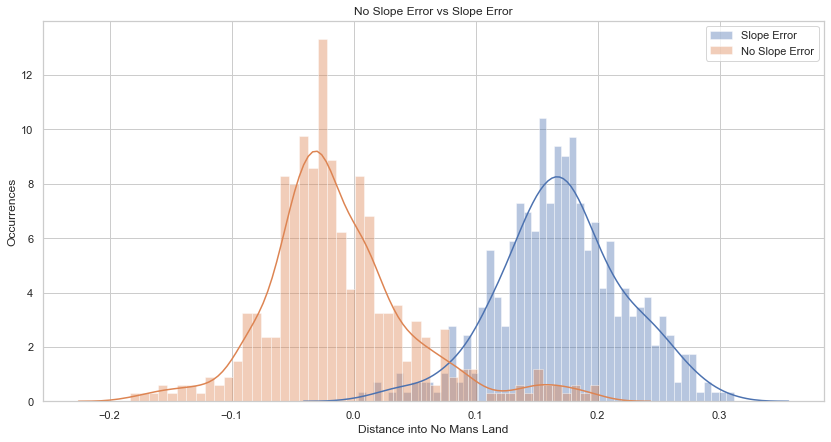

In [16]:
plt.figure(figsize=(14, 7))
sns.distplot(original_data[original_data['target']==1]['susness'], rug=False, bins=50, label='Slope Error')
sns.distplot(original_data[original_data['target']==0]['susness'], rug=False, bins=50, label='No Slope Error')
plt.title('No Slope Error vs Slope Error')
plt.xlabel('Distance into No Mans Land')
plt.ylabel('Occurrences')
plt.legend()

In [12]:
from data_transformation import get_suspicious_peaks, get_ranges, get_peak_suspiciousness
original_data = dg.calibrated_df(True, .005, .01,use_ranges=True, ranges=[0, 0, 0.5], cat=True)
ranges = get_ranges(isotope_data, 2000)
original_data['sus_peaks'] = original_data['masses'].apply(get_suspicious_peaks, args=(ranges, .1))
original_data['peak_sussness'] = original_data['masses'].apply(get_peak_suspiciousness, args=(ranges, True))

In [13]:
original_data['susness'] = original_data['peak_sussness'].apply(np.mean)

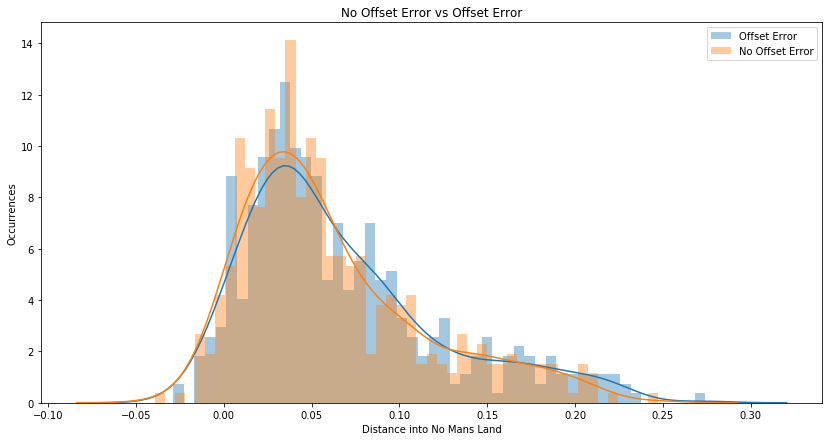

In [15]:
plt.figure(figsize=(14, 7))
sns.distplot(original_data[original_data['target']==1]['susness'], rug=False, bins=50, label='Offset Error')
sns.distplot(original_data[original_data['target']==0]['susness'], rug=False, bins=50, label='No Offset Error')
plt.title('No Offset Error vs Offset Error')
plt.xlabel('Distance into No Mans Land')
plt.ylabel('Occurrences')
plt.legend()

In [21]:
def get_xs(data, x=12):
    xs = []
    for row in data.itertuples():
        row_x = -1
        max = -1
        for i, mass in enumerate(row.masses):
            dif = abs(mass-x)
            inten = row.intensities[i]
            if dif < 0.1 and (inten > max or max == -1):
                max = inten
                row_x = dif
        xs.append(row_x)
    return xs
original_data['twelves'] = get_xs(original_data)

In [23]:
original_data[original_data['twelves'] != -1][['twelves', 'target']].describe()

,twelves,target
count,8.740000e+02,874.000000
mean,3.721288e-03,0.494279
std,6.408331e-03,0.500254
min,3.579547e-07,0.000000
25%,3.634876e-04,0.000000
50%,7.018230e-04,0.000000
75%,4.130957e-03,1.000000
max,3.547915e-02,1.000000


In [24]:
np.mean(original_data[(original_data['target'] == 1) & (original_data['twelves'] != -1)]['twelves'])

0.005139637106760032

In [25]:
np.std(original_data[(original_data['target'] == 1) & (original_data['twelves'] != -1)]['twelves'])

0.0072724082680673974

In [26]:
np.mean(original_data[(original_data['target'] == 0) & (original_data['twelves'] != -1)]['twelves'])

0.0023350272986277505

In [27]:
np.std(original_data[(original_data['target'] == 0) & (original_data['twelves'] != -1)]['twelves'])

0.005052930673140101

In [28]:
len(original_data[original_data['twelves'] == -1]['twelves'])

32

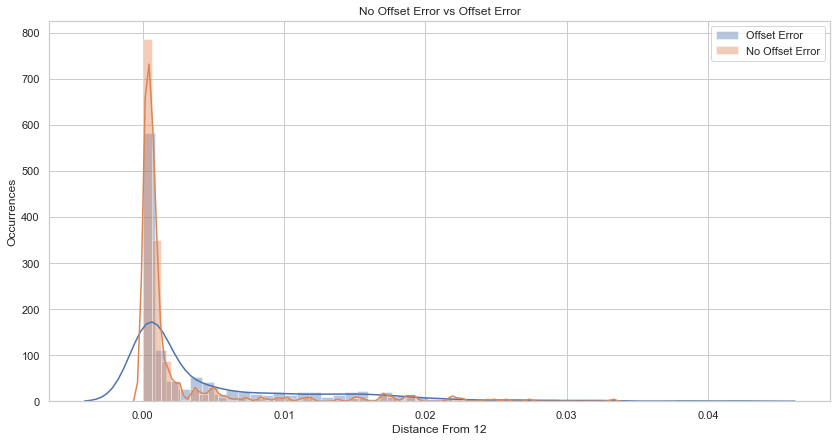

In [53]:
plt.figure(figsize=(14, 7))
sns.distplot(original_data[(original_data['target'] == 1) & (original_data['twelves'] != -1)]['twelves'], rug=False, bins=50, label='Offset Error')
sns.distplot(original_data[(original_data['target'] == 0) & (original_data['twelves'] != -1)]['twelves'], rug=False, bins=50, label='No Offset Error')
plt.title('No Offset Error vs Offset Error')
plt.xlabel('Distance From 12')
plt.ylabel('Occurrences')
plt.legend()

In [27]:
df = pd.read_csv('../data/processed_cas.csv')
for column in df.columns:
    try:
        df[column] = df[column].apply(str.strip)
    except:
        pass
df.drop('Unnamed: 0', inplace=True, axis=1)

In [71]:
df['Calibration'][5]

'8 (15.023422, CH3, 15.023475) (27.023067, C2H3, 27.023475) (55.054122, C4H7, 55.054775) (69.070613, C5H9, 69.070425) (83.087059, C6H11, 83.086075) (95.087318, C7H11, 95.086075) (283.262196, C18H35O2, 283.263675) (311.295154, C20H39O2, 311.294975)'

In [73]:
isotope_data.loc[5:30]

,Element,Isotope Masses,Isotope Frequencies
5,Carbon,"[12.0, 13.00335, 14.003242]","[0.98892, 0.01108, 0.0]"
6,Nitrogen,"[14.00307, 15.00011]","[0.99635, 0.00365]"
7,Oxygen,"[15.9949, 16.99913, 17.99916]","[0.99759, 0.00037, 0.00204]"
8,Fluorine,[18.9984],[1.0]
9,Neon,"[19.9924, 20.9938, 21.99138]","[0.9092, 0.00257, 0.0882]"
10,Sodium,[22.98977],[1.0]
11,Magnesium,"[23.985, 24.9858, 25.9826]","[0.786, 0.1011, 0.1129]"
12,Aluminum,[26.98154],[1.0]
13,Silicon,"[27.97693, 28.9765, 29.97377]","[0.9218, 0.0471, 0.0312]"
14,Phosphorous,[30.97376],[1.0]


In [29]:
unchanged_data = dg.calibrated_df()

In [30]:
changed_data = dg.calibrated_df(True, .005, .01,use_ranges=True, ranges=[0, 0, 1], cat=True)

In [31]:
unchanged_data['Cs'] = get_xs(unchanged_data)
unchanged_data['CHs'] = get_xs(unchanged_data, x=13.007825)
unchanged_data['CH3s'] = get_xs(unchanged_data, x=15.023475)
unchanged_data['C2Hs'] = get_xs(unchanged_data, x=25.007825)
unchanged_data['C3H5s'] = get_xs(unchanged_data, x=41.0391255)

In [35]:
dists = unchanged_data[['Cs', 'CHs','CH3s', 'C2Hs', 'C3H5s','file_name']].copy()
dists = dists.sort_values(['C3H5s'], ascending=False)
dists.reset_index(inplace=True, drop=True)

In [33]:
dists.to_csv('dists_from_unique_spots.csv')

In [37]:
dists['C3H5s'][405]

0.02545445949758829

In [150]:
good_examples = dists.loc[450:]

In [124]:
changed_data['Cs'] = get_xs(changed_data)
changed_data['CHs'] = get_xs(changed_data, x=13.007825)
changed_data['CH3s'] = get_xs(changed_data, x=15.023475)
changed_data['C2Hs'] = get_xs(changed_data, x=25.007825)
changed_data['C3H5s'] = get_xs(changed_data, x=41.0391255)

In [126]:
offset_dists = changed_data[['Cs', 'CHs','CH3s', 'C2Hs', 'C3H5s','file_name', 'target']]

In [145]:
offset_dists = offset_dists.sort_values(['Cs', 'CHs', 'CH3s'], ascending=False)
offset_dists.reset_index(inplace=True, drop=True)

In [135]:
from data_transformation import mass_formula

In [151]:
good_examples = np.hstack([np.array(good_examples.drop('file_name', axis=1)), np.zeros((456, 1))])

In [153]:
bad_examples = np.array(offset_dists.drop('file_name', axis=1))

In [156]:
training_data = np.vstack([good_examples, bad_examples])

In [177]:
X = training_data[:, 0:5]
y = training_data[:, 5]

In [178]:
models = [RandomForestClassifier, LGBMClassifier, XGBClassifier]
names = ['rfc', 'lgbm', 'xgb']
mt = ModelTrainer(models, X, y, names)

In [179]:
accs, indices_preds = mt.kfold_models(5, model_params=[{'n_estimators': 10}, {}, {}])
accs

[0.2879928894634777, 0.28430833872010347, 0.2887254901960784]

In [180]:
len(good_examples)

456

In [181]:
len(bad_examples)

906

In [182]:
len(good_examples) / (len(good_examples) + len(bad_examples))

0.33480176211453744